In [1]:
import numpy as np
from numpy import diff
from scipy.integrate import solve_ivp
from scipy.integrate import quad
import matplotlib.pyplot as plt

#Some plot settings
import matplotlib as mpl
mpl.rcParams['mathtext.rm'] = 'serif'
mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 16
mpl.rcParams['text.usetex'] = False

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

# smoothing filter
from scipy.signal import savgol_filter

/var/folders/sc/hq5cw73j2c10910m2lq9c83c0000gn/T/ipykernel_782/4021170420.py:15: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


# Solución numérica Eq. (2.6) Tkachev

##### EDO: 

$ x(1+x)R''+(1+\frac{3x}{2})R'+\frac{1}{2}(\frac{M_t}{\frac{4\pi \rho_e a_e^3}{3}\xi^3 R^2}-R)=0 $

The total mass $M_t$ is the mass inside $R\xi$. 

But $M_t$ appears divided by the "average mass" inside the initial volume $\frac{4\pi \rho_e a_e^3}{3}\xi^3$ so we can define

$\bar M_t = \frac{M_t}{\frac{4\pi \rho_e a_e^3}{3}\xi^3}$

This "relative mass fraction" is like an over(under)density that can remain constant IF THERE IS NO SHELL CROSSING. 
So Tkachev and Kolb called it $1+\Phi$, so 

$1+\Phi = \bar M_t = \frac{M_t}{\frac{4\pi \rho_e a_e^3}{3}\xi^3}=\frac{\int_0^{r(\xi)}dr 4\pi r^2 \rho(r)}{\frac{4\pi \rho_e a_e^3}{3}\xi^3}$

We can write

$ x(1+x)R''+(1+\frac{3x}{2})R'+\frac{1}{2}(\frac{\bar M_t(\xi)(x)}{R^2}-R)=0 $

$ x(1+x)R''+(1+\frac{3x}{2})R'+\frac{1}{2}(\frac{1+\Phi_i(x)}{R^2}-R)=0 $

where we have highlighed that $\bar M,\Phi$ can change in time. 

We will calculate $M$ as the sum over shell masses. 

We define a set of $\xi$'s $\xi = 0,1,2,3... $ and th3 shell particle, which has mass 

$m_{\xi_i} = m_i = \int_{\xi_i}^{\xi_{i+1}} \frac{dM}{dr}$, $\frac{dM}{dr}= 4\pi \xi^2 \rho(\xi)$

Text(0, 0.5, '$ M(\\xi_i)$ (unidades de $\\langle\\rho_{DM}\\rangle \\xi^3$)')

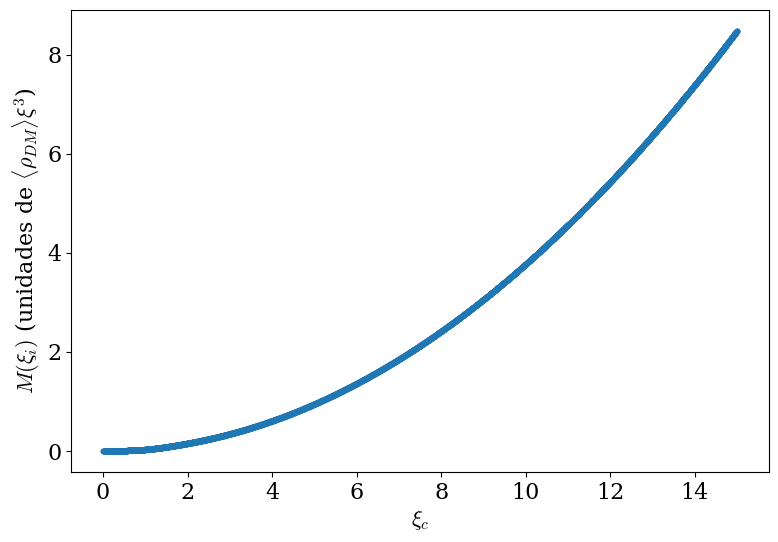

In [2]:
# shell borders until x = 10 
xi = np.linspace(0,1,5000)**(1/1)* 15
# shell centers
xic = 0.5*(xi[1:]+xi[:-1])
# INITIAL density profile, parameter rho0 is the central density
# Normalised to rho_DM_average (i.e. we need rho_i(r->inf)=1)

def rho_i(xi,rho0,xi_v):
    return (1 - (1-rho0)*np.exp(-(xi-xi_v)**2))
def dMdxi_i(xi,rho0,xi_v):
    return (4*np.pi*xi**2) * rho_i(xi,rho0,xi_v)

# central density and radius
rho0, xi_v = 0.1, 0

plt.figure(figsize=(9,6))
#shell mass
m_xi = xic*0
for i in range(len(xi)-1):
    m_xi[i] = quad(dMdxi_i, xi[i], xi[i+1],args=(rho0, xi_v))[0]
plt.plot(xic,m_xi,'.')
#plt.plot(xic[200],m_xi[200],'.r')
plt.xlabel(r'$\xi_c$');plt.ylabel(r'$ M(\xi_i)$ (unidades de $\langle\rho_{DM}\rangle \xi^3$)')
#plt.savefig('shellmassR2def.pdf')

# Evolution

Reduce to 1st order diff. eq. using $R' = P$

$x(x+1)P' = -(1+\frac{3x}{2})P-\frac{1}{2}(\frac{\bar M_t(\xi)(x)}{R^2}-R)$

$R' = P$

iteration 

$x(x+1)(P_+-P_-) = -(1+\frac{3x}{2})\frac{P_++P_-}{2}\Delta x -\Delta x \frac{1}{2}(\frac{\bar M_t(\xi)(x)}{R^2}-R)$

$P_+ = P_-\frac{x(x+1)-(1+3x/2)\Delta x/2}{x(x+1)+(1+3x/2)\Delta x/2} - \frac{\Delta x}{x(x+1)+(1+3x/2)\Delta x/2} \frac{1}{2}(\frac{\bar  M_t(\xi)(x)}{R^2}-R)$

$R_+ = R_- + P\Delta x$


In [3]:
def itera(P,R,Dx,x,bMT):
    # P, R, MT are the values of P,R, bar M_T for each shell
    a = x*(x+1)-(1+3*x/2)*Dx/2
    b = x*(x+1)+(1+3*x/2)*Dx/2
    aP = P*a/b - Dx/b * 1/2 * (bMT/R**2-R)
    return aP, R + aP*Dx



# def evi(x,dxpar):
    

# Calculate $\bar M_T=1+\Phi$

We sum the masses of all points inside the physical distance $r$ and divide by the comoving volume

$1+\Phi = \bar M_t = \frac{M_t}{\frac{4\pi \rho_e a_e^3}{3}\xi^3}=
\frac{1}{\frac{4\pi \rho_e a_e^3}{3}\xi^3}
\sum_{j/ r_j<r_i} M_{\xi_j}$

the discretisation works as ... $\int_0^{r(\xi)}dr 4\pi r^2 \rho(r)=\int dr \frac{dM}{dr}=\sum M$

In [4]:
#def bMT(xic,m_xi,R):
 #   bMT= m_xi*0
  #  for i in range(len(xic)):
   #     bMT[i] = m_xi[np.abs(xic*R) < np.abs(xic[i]*R[i])].sum()    #sumamos todas las masas contenidas
    #return np.array(bMT)/(4*np.pi*xic**3/3)

def bMT(xi,m_xi,R,verbose=0):
    # mass inside boundary i
    bMT= xi*0 
    ii = np.arange(len(m_xi))
    boundaries = np.abs(xi*R)
    # lower un upper boundary
    b0 = boundaries[:-1]
    b1 = boundaries[1:]
    # check every boundary over boundaries
    for i in range(1,len(xi)):
        pb = boundaries[i]
        b0inm = (b0<=pb)
        b1inm = (b1<=pb)
        bMT[i] = m_xi[ np.logical_and(b0inm,b1inm)].sum()    #add all shells with both boundaries inside
        # crossed shells computed apart
        parti = bMT[i]/(4*np.pi*xi[i]**3/3)
        mm = np.logical_or(np.logical_and(b0inm,~b1inm),np.logical_and(~b0inm,b1inm))
        collection = ii[mm]
        if verbose>0 and len(collection)>0:
            print('i %d collecti0n '%(i),collection,parti)
        for shell in collection:
            # calculate mass inside boundary i assuming constant density in shell
            # m_i = int rho 4pi r^2 dr = bbb (r1^3-r0^3)
            # m_i_inside is bbb (pb^3-min(r0,r1)^3) = m_i (pb^3-min(r0,r1)^3)/abs((r1^3-r0^3))
            mshellinside= m_xi[shell] * (pb**3-min(b0[shell],b1[shell])**3)/np.abs(b0[shell]**3-b1[shell]**3)
            if verbose>0:
                print('i %d shell %d, %.2f/%.2f b0 %f b1 %f'%(i,shell,mshellinside,m_xi[shell],b0[shell],b1[shell]))
            bMT[i] += mshellinside
    aux= bMT[1:]/(4*np.pi*xi**3/3)[1:]
    a2 = xi*0
    a2[1:]=aux
    a2[0]=aux[0]
    return a2

(0.0, 1.1)

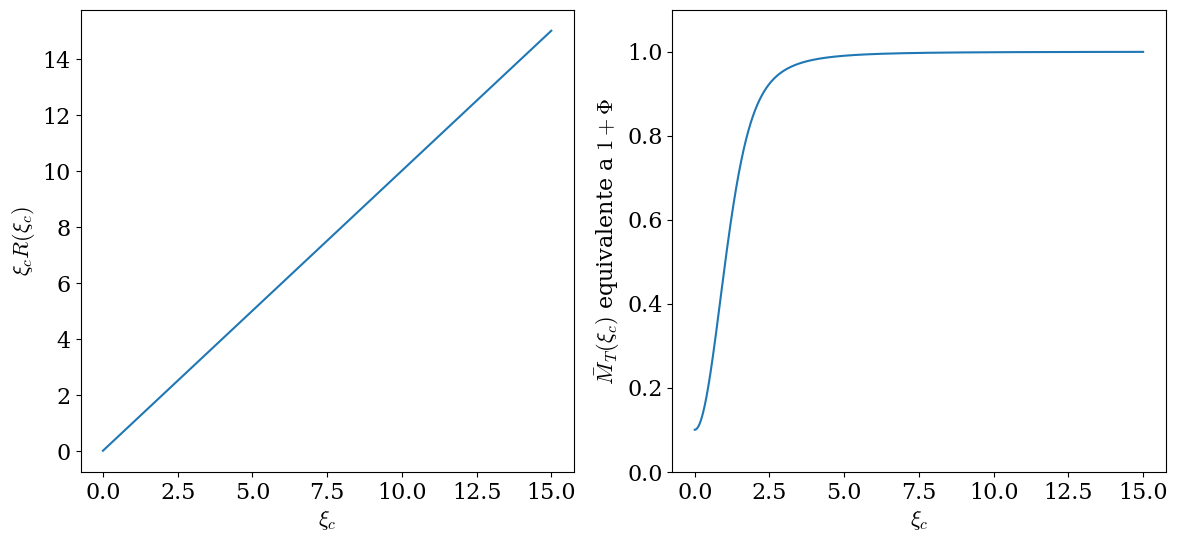

In [5]:
R=np.ones(len(xi))
bMT_0= bMT(xi,m_xi,R,verbose=0)

fig,ax=plt.subplots(1,2,figsize=(14,6))
ax[0].plot(xi,xi*R)
ax[0].set_xlabel(r'$\xi_c$');ax[0].set_ylabel(r'$\xi_c R(\xi_c)$')

ax[1].plot(xi,bMT_0)
#ax[1].plot(xic,1-(xi_v/xic)**3,'k--')
ax[1].set_xlabel(r'$\xi_c$');ax[1].set_ylabel(r'$\bar M_T(\xi_c)$ equivalente a $1+\Phi$')

ax[1].set_ylim(0,1.1)
#plt.savefig('totalmassr2.pdf')

In [6]:
# Define arrays
x = 1e-3
Rd  = R
Pd  = R*0
bMTd = bMT(xi,m_xi,Rd)
Rdl = []
Pdl = []
bMTl = []
xl  = []

In [184]:
# Evolve
#def evolo(it_number,x,Rd,Pd,bMTd,Rdl, Pdl, bMTl,xl,dxpar=10):

para      = 6
it_number = 120 * para
dxpar     = 10  * para
ditsave   = 1   * para
for i in range(it_number):
    Dx = x/dxpar
    Pd, Rd = itera(Pd,Rd,Dx,x,bMTd)
    bMTd = bMT(xi,m_xi,Rd)
    x=x+Dx
    if i%ditsave == 0:
        Pdl.append(Pd)
        Rdl.append(Rd)
        bMTl.append(bMTd)
        xl.append(x)
Pdla=np.array(Pdl)
Rdla=np.array(Rdl)
bMTla=np.array(bMTl)
xla= np.array(xl)

#    return Pdla, Rdla, bMTla, xla
#Pdla, Rdla, bMTla, xla = evolo(3,x,Rd,Pd,bMTd,Rdl, Pdl, bMTl,xl,dxpar=10)

# Results

Text(0, 0.5, '$r_i = \\xi R(\\xi)$')

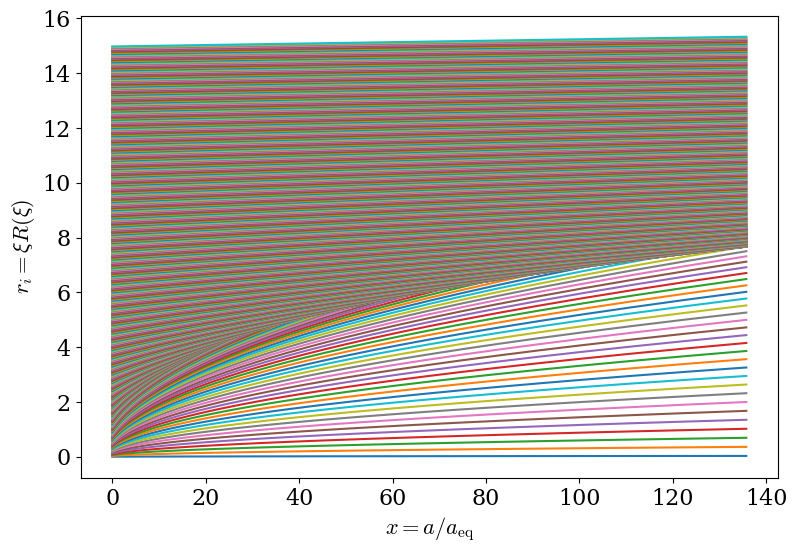

In [185]:
plt.figure(figsize=(9,6))
for i in range(1, len(xic)-1, 10):
    plt.plot(xla, xi[i]*Rdla[:,i],'-',label=r'$\xi = %d$'%i) 
    
#plt.plot(xla, xi[200]*Rdla[:,200],'w-',lw=2) 
    #plt.plot(xla, np.sqrt(1-((MTla[0,i]-1)*xla)))
plt.xlabel(r'$x=a/a_{\rm eq}$');plt.ylabel(r'$r_i = \xi R(\xi)$')
#plt.legend(prop={'size': 8})
#plt.savefig('shellevolutionr2.pdf')

/var/folders/sc/hq5cw73j2c10910m2lq9c83c0000gn/T/ipykernel_744/3769615814.py:23: RuntimeWarning: divide by zero encountered in divide
  rho = np.gradient(smooth_mass_ord,r_tab_reg)/(4*np.pi*r_tab_reg**2)


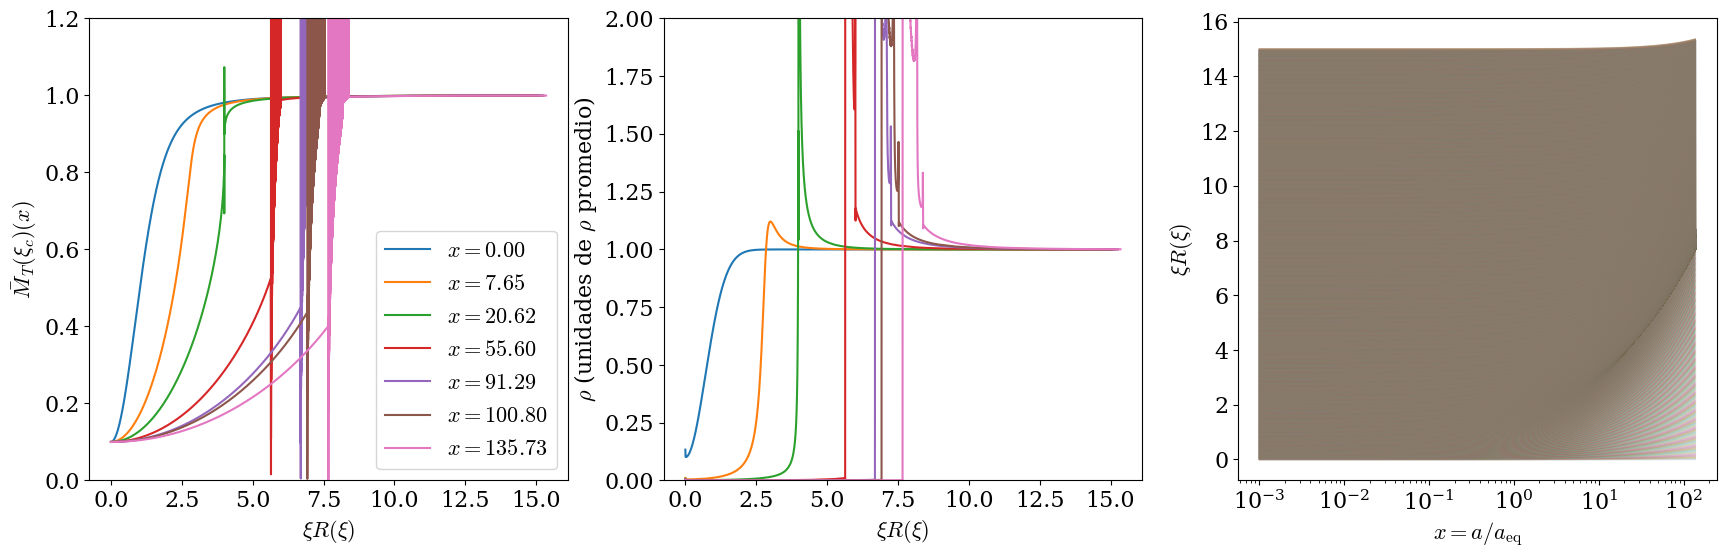

In [186]:
fig,ax=plt.subplots(1,3,figsize=(21,6))


for i in [0,-30,-20,-10,-5,-4,-1]:
    # physical coordinate radius
    ri =xi*Rdla[i]
    
    # ordering based on distance to center
    ord_ri = np.argsort(ri)
    ri_ord = ri[ord_ri]
           
    # Mass
    mass_ord = (bMTla[i]*4*np.pi/3*xi**3)[ord_ri]
    # Phi 
    Phi_ord = (bMTla[i])[ord_ri]
    ax[0].plot(ri_ord,Phi_ord,'-',label=r'$x = %.2f$'%xl[i])

    # local density estimate build from (dM/dr)/4pir^2
    # Recall bMT = Mass/4pixi^3/3
    r_tab_reg = np.linspace(ri_ord[0],ri_ord[-1],len(ri_ord))
    minterp = np.interp(r_tab_reg, ri_ord, mass_ord)
    smooth_mass_ord = savgol_filter(minterp, 5, 3)
    rho = np.gradient(smooth_mass_ord,r_tab_reg)/(4*np.pi*r_tab_reg**2)

    ax[1].plot(r_tab_reg,rho)
    
    
ax[1].set_ylim(0,2)
ax[0].set_ylim(0,1.2)
for i in range(len(xic)):
    ax[2].semilogx(xla,xic[i]*Rdla[:,i],label=r'$\xi = %.2f$'%xic[i],alpha=0.2)
ax[0].set_xlabel(r'$\xi R(\xi)$');ax[0].set_ylabel(r'$\bar M_T(\xi_c)(x)$')
ax[1].set_xlabel(r'$\xi R(\xi)$');ax[1].set_ylabel(r'$\rho$ (unidades de $\rho$ promedio)')
ax[2].set_xlabel(r'$x=a/a_{\rm eq}$');ax[2].set_ylabel(r'$\xi R(\xi)$')
ax[0].legend()
#ax[1].legend()

#plt.savefig('massdensityevolr2.pdf')

/var/folders/sc/hq5cw73j2c10910m2lq9c83c0000gn/T/ipykernel_744/2738466219.py:23: RuntimeWarning: divide by zero encountered in divide
  rho = np.gradient(smooth_mass_ord,r_tab_reg)/(4*np.pi*r_tab_reg**2)


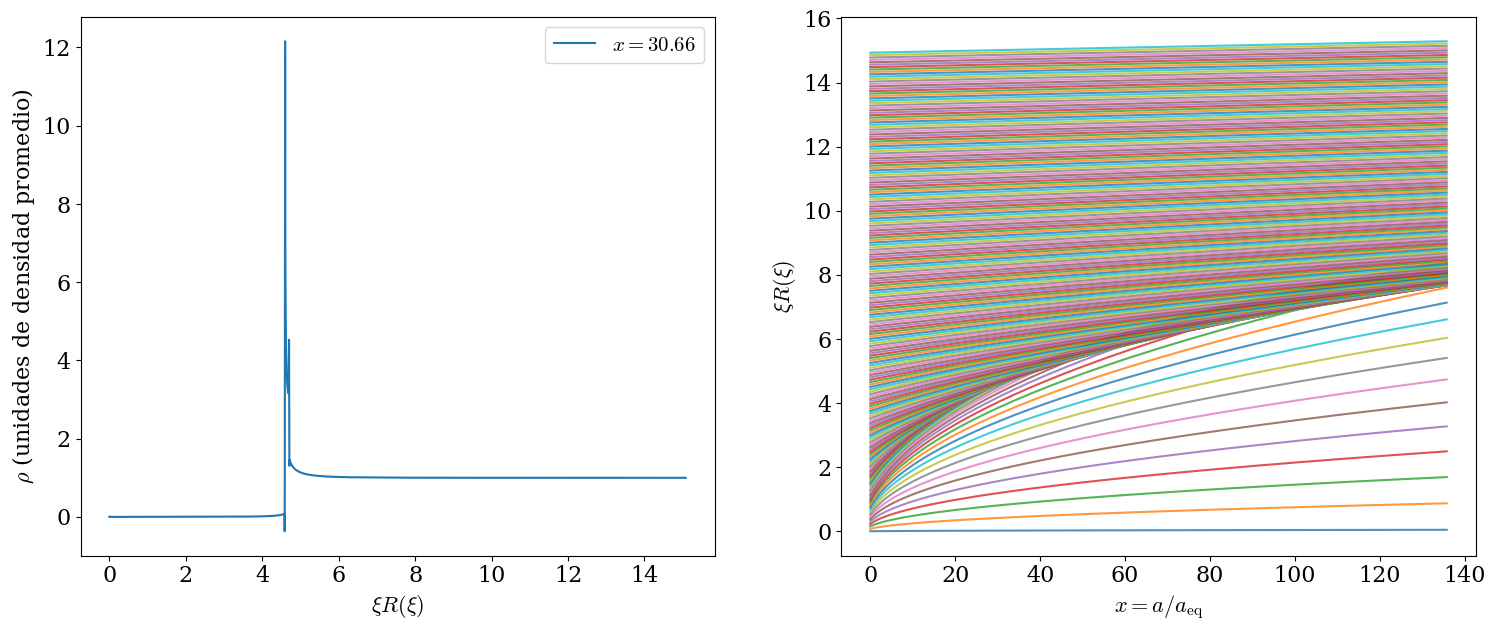

In [187]:
fig,ax=plt.subplots(1,2,figsize=(18,7))


for i in [104]:#[104]:#[0,-50,-40,-30,-20,-10,-5,-1]:
    # physical coordinate radius
    ri =xi*Rdla[i]
    
    # ordering based on distance to center
    ord_ri = np.argsort(ri)
    ri_ord = ri[ord_ri]
           
    # Mass
    mass_ord = (bMTla[i]*4*np.pi/3*xi**3)[ord_ri]
    # Phi 
    Phi_ord = (bMTla[i])[ord_ri]
    #ax[0].plot(ri_ord,Phi_ord,'-',label=r'$x = %.2f$'%xl[i])

    # local density estimate build from (dM/dr)/4pir^2
    # Recall bMT = Mass/4pixi^3/3
    r_tab_reg = np.linspace(ri_ord[0],ri_ord[-1],len(ri_ord))
    minterp = np.interp(r_tab_reg, ri_ord, mass_ord)
    smooth_mass_ord = savgol_filter(minterp, 5, 3)
    rho = np.gradient(smooth_mass_ord,r_tab_reg)/(4*np.pi*r_tab_reg**2)

    ax[0].plot(r_tab_reg,rho,label=r'$x = %.2f$'%xl[i])
    
#ax[1].set_ylim(0,2)
#ax[0].set_xlim(0,10)
for i in range(1, len(xic)-1, 25):#range(len(xic)):
    ax[1].plot(xla,xic[i]*Rdla[:,i],label=r'$\xi = %.2f$'%xic[i],alpha=0.8)
#ax[0].set_xlabel(r'$\xi R(\xi)$');ax[0].set_ylabel(r'$\bar M_T(\xi_c)(x)$')
ax[0].set_xlabel(r'$\xi R(\xi)$');ax[0].set_ylabel(r'$\rho$ (unidades de densidad promedio)')
ax[1].set_xlabel(r'$x=a/a_{\rm eq}$');ax[1].set_ylabel(r'$\xi R(\xi)$')
ax[0].legend(prop={'size': 15})
#ax[1].legend()
#ax[0].set_xlim(5.5,6)
#plt.savefig('densityevolconverge.pdf')

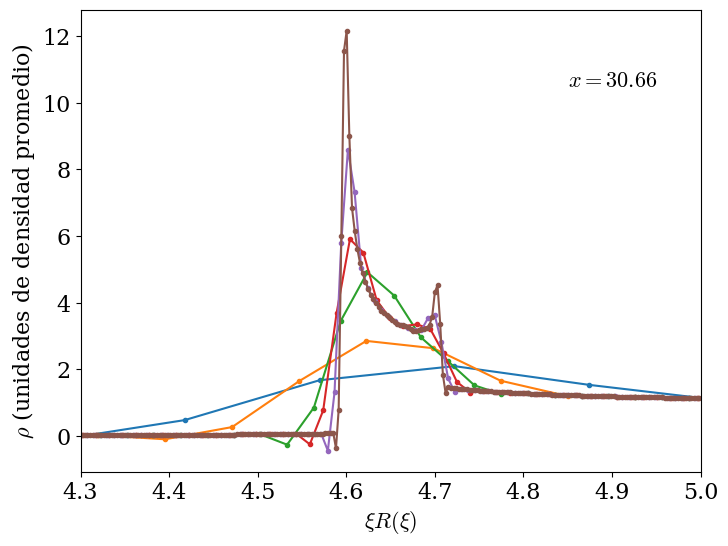

In [193]:
xiR15_5000=r_tab_reg
rho15_5000=rho
#np.save('xiR15_5000.npy', xiR15_5000);np.savetxt('xiR15_5000.txt', xiR15_5000)
#np.save('rho15_5000.npy', rho15_5000);np.savetxt('rho15_5000.txt', rho15_5000)

fig,ax=plt.subplots(1,1,figsize=(8,6))

ax.plot(xiR15_100,rho15_100,'.-',label=r'$100$ cáscaras')
ax.plot(xiR15_200,rho15_200,'.-',label=r'$200$')
ax.plot(xiR15_500,rho15_500,'.-',label=r'$500$')
ax.plot(xiR15_1000,rho15_1000,'.-',label=r'$1000$')
ax.plot(xiR15_2000,rho15_2000,'.-',label=r'$2000$')
ax.plot(xiR15_5000,rho15_5000,'.-',label=r'$5000$')
#ax.plot(xiR15_10000,rho15_10000,label=r'$10000$')


ax.text(4.85,11,'$x = %.2f$'%30.66,fontsize=16,horizontalalignment='left',verticalalignment='top')
ax.set_xlim(4.3,5.0)
ax.set_xlabel(r'$\xi R(\xi)$');ax.set_ylabel(r'$\rho$ (unidades de densidad promedio)')
#ax.legend()
#plt.savefig('SCconverge30.pdf')

(3.8, 5.0)

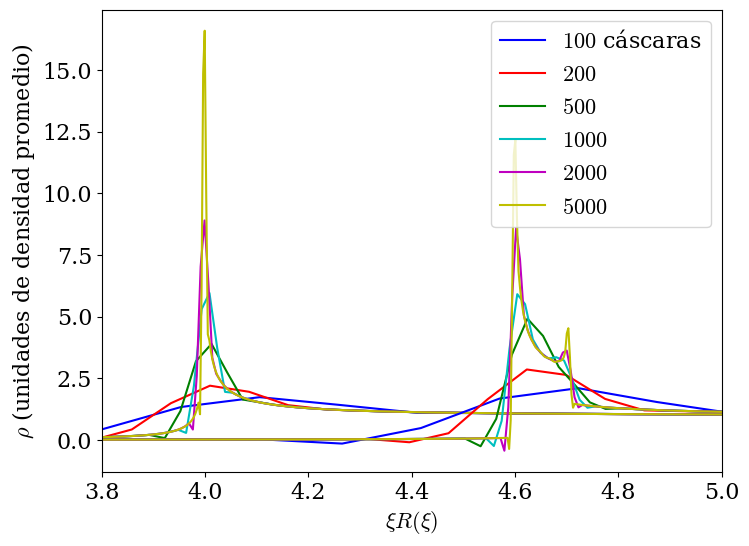

In [12]:
# PLOT CONJUNTO
fig,ax=plt.subplots(1,1,figsize=(8,6))

p1=np.load('npys-txts-c20/rho15_100.npy')
p2=np.load('npys-txts-c20/rho15_200.npy')
p3=np.load('npys-txts-c20/rho15_500.npy')
p4=np.load('npys-txts-c20/rho15_1000.npy')
p5=np.load('npys-txts-c20/rho15_2000.npy')
p6=np.load('npys-txts-c20/rho15_5000.npy')
q1=np.load('npys-txts-c20/xiR15_100.npy')
q2=np.load('npys-txts-c20/xiR15_200.npy')
q3=np.load('npys-txts-c20/xiR15_500.npy')
q4=np.load('npys-txts-c20/xiR15_1000.npy')
q5=np.load('npys-txts-c20/xiR15_2000.npy')
q6=np.load('npys-txts-c20/xiR15_5000.npy')

p7=np.load('npys-txts-c30/rho15_100.npy')
p8=np.load('npys-txts-c30/rho15_200.npy')
p9=np.load('npys-txts-c30/rho15_500.npy')
p10=np.load('npys-txts-c30/rho15_1000.npy')
p11=np.load('npys-txts-c30/rho15_2000.npy')
p12=np.load('npys-txts-c30/rho15_5000.npy')
q7=np.load('npys-txts-c30/xiR15_100.npy')
q8=np.load('npys-txts-c30/xiR15_200.npy')
q9=np.load('npys-txts-c30/xiR15_500.npy')
q10=np.load('npys-txts-c30/xiR15_1000.npy')
q11=np.load('npys-txts-c30/xiR15_2000.npy')
q12=np.load('npys-txts-c30/xiR15_5000.npy')

#Poner mismos colores entre mismo n de cascaras!
ax.plot(q1,p1,'b-',label=r'$100$ cáscaras')
ax.plot(q2,p2,'r-',label=r'$200$')
ax.plot(q3,p3,'g-',label=r'$500$')
ax.plot(q4,p4,'c-',label=r'$1000$')
ax.plot(q5,p5,'m-',label=r'$2000$')
ax.plot(q6,p6,'y-',label=r'$5000$')
ax.plot(q7,p7,'b-')#,label=r'$100$ cáscaras')
ax.plot(q8,p8,'r-')#,label=r'$200$')
ax.plot(q9,p9,'g-')#,label=r'$500$')
ax.plot(q10,p10,'c-')#,label=r'$1000$')
ax.plot(q11,p11,'m-')#,label=r'$2000$')
ax.plot(q12,p12,'y-')#,label=r'$5000$')

ax.set_xlabel(r'$\xi R(\xi)$');ax.set_ylabel(r'$\rho$ (unidades de densidad promedio)')
ax.legend()
ax.set_xlim(3.8,5.0)
#plt.savefig('SCconverge20-30.pdf')

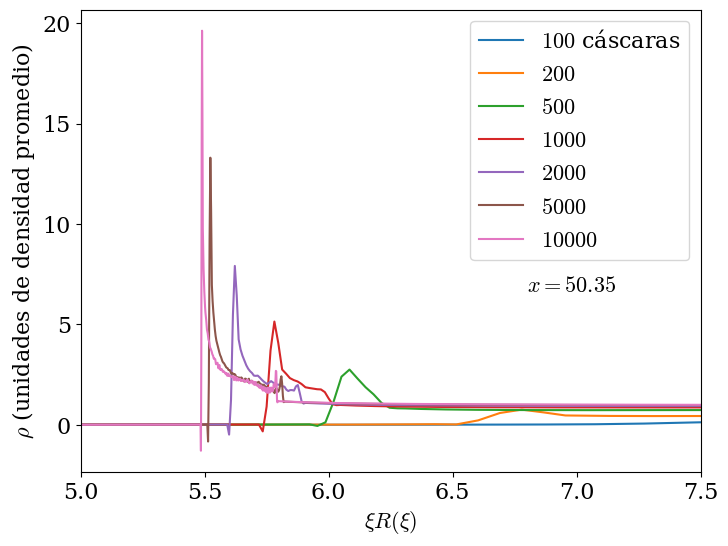

In [195]:
#xiR15_2000=r_tab_reg
#rho15_2000=rho

fig,ax=plt.subplots(1,1,figsize=(8,6))

for i in [-1]:
    ax.plot(xiR15_100,rho15_100,label=r'$100$ cáscaras')
    ax.plot(xiR15_200,rho15_200,label=r'$200$')
    ax.plot(xiR15_500,rho15_500,label=r'$500$')
    ax.plot(xiR15_1000,rho15_1000,label=r'$1000$')
    ax.plot(xiR15_2000,rho15_2000,label=r'$2000$')
    ax.plot(xiR15_5000,rho15_5000,label=r'$5000$')
    ax.plot(xiR15_10000,rho15_10000,label=r'$10000$')
  
ax.text(6.8,7.5,'$x = %.2f$'%50.35,fontsize=16,horizontalalignment='left',verticalalignment='top')
ax.set_xlim(5,7.5)
ax.set_xlabel(r'$\xi R(\xi)$');ax.set_ylabel(r'$\rho$ (unidades de densidad promedio)')
ax.legend()
#plt.savefig('densityconverge.pdf')

In [1]:
fig,ax=plt.subplots(1,figsize=(8,6))


for i in range(0,80):
    # physical coordinate radius
    ri =xic*Rdla[i]
    
    # ordering based on distance to center
    ord_ri = np.argsort(ri)
    ri_ord = ri[ord_ri]
           
    # Mass
    mass_ord = (bMTla[i]*4*np.pi/3*xic**3)[ord_ri]
    # Phi 
    Phi_ord = (bMTla[i])[ord_ri]

    # local density estimate build from (dM/dr)/4pir^2
    # Recall bMT = Mass/4pixi^3/3
    r_tab_reg = np.linspace(ri_ord[0],ri_ord[-1],len(ri_ord))
    minterp = np.interp(r_tab_reg, ri_ord, mass_ord)
    smooth_mass_ord = savgol_filter(minterp, 5, 3)
    rho = np.gradient(smooth_mass_ord,r_tab_reg)/(4*np.pi*r_tab_reg**2)
   
    # 
    b = ((rho - 0.5)**2).argmin()
    rho_der = np.gradient(rho,r_tab_reg)
    ax.semilogy(xla[i],rho_der[b],'x')
    
    ax.semilogy(xla,10/(5.5-xla)**1.5)
ax.set_xlim(0,6)
ax.set_ylim(0.1,10)

NameError: name 'plt' is not defined

In [12]:
# Normalise to void boundary

Rdla.shape

(110, 999)

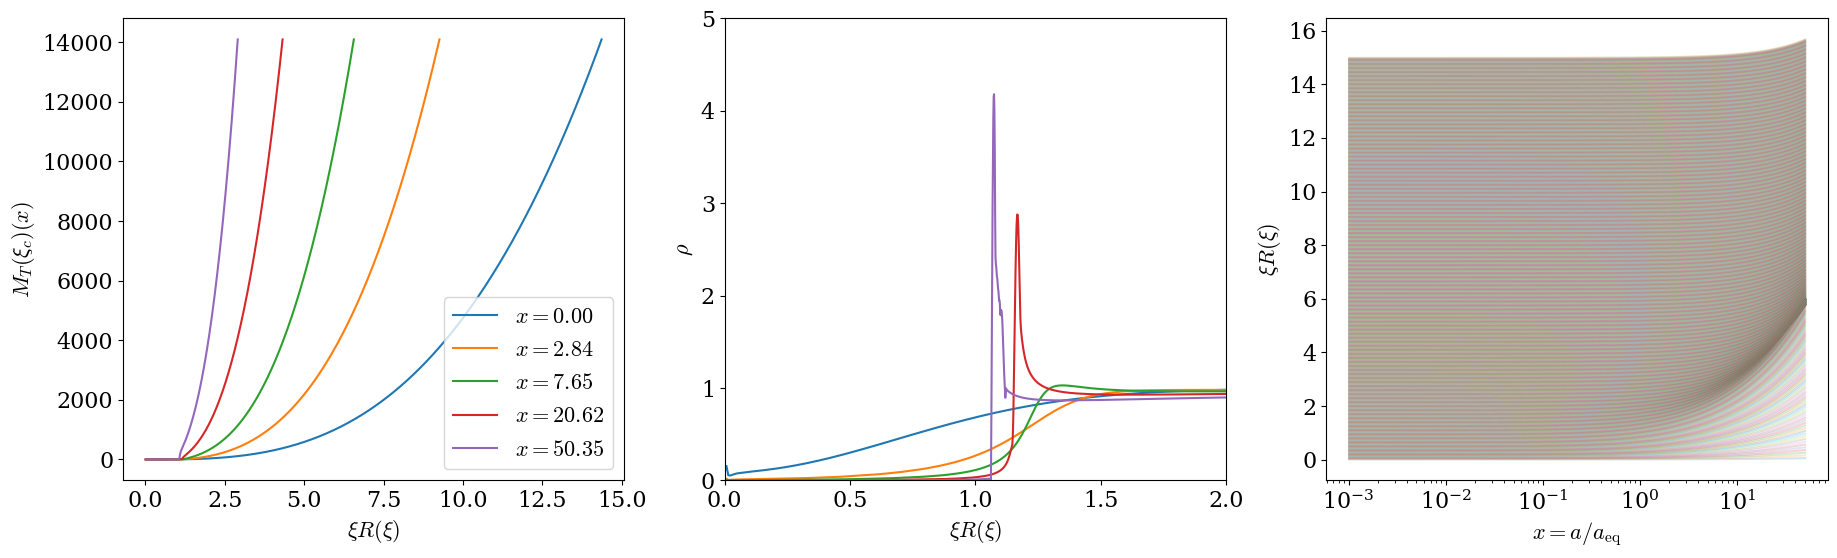

In [13]:
fig,ax=plt.subplots(1,3,figsize=(22,6))

for i in [1,-30,-20,-10,-1]:
    # physical coordinate radius
    ri =xic*Rdla[i]

    # ordering based on distance to center
    ord_ri = np.argsort(ri)
    ri_ord = ri[ord_ri]

    # Mass
    mass_ord = (bMTla[i]*4*np.pi/3*xic**3)[ord_ri]
    # Phi 
    Phi_ord = (bMTla[i])[ord_ri]

    # Point where Phi=-0.5

    b = ((Phi_ord-0.5)**2).argmin()
    r_norm = ri_ord[b]

    ax[0].plot(ri_ord/r_norm,mass_ord,'-',label=r'$x = %.2f$'%xl[i])
    
           
    # local density estimate build from (dM/dr)/4pir^2
    # Recall bMT = Mass/4pixi^3/3
    r_tab_reg = np.linspace(ri_ord[0],ri_ord[-1],2*len(ri_ord))
    minterp = np.interp(r_tab_reg, ri_ord, mass_ord)
    smooth_mass_ord = savgol_filter(minterp, 15, 3)
    rho = np.gradient(smooth_mass_ord,r_tab_reg)/(4*np.pi*r_tab_reg**2)

    ax[1].plot(r_tab_reg/r_norm,rho)
#ax[0].set_xlim(0.9,1.10)
ax[1].set_xlim(0,2.0)
ax[1].set_ylim(0,5.0)
for i in range(len(xic)):
    ax[2].semilogx(xla,xic[i]*Rdla[:,i],label=r'$\xi = %.2f$'%xic[i],alpha=0.2)
ax[0].set_xlabel(r'$\xi R(\xi)$');ax[0].set_ylabel(r'$M_T(\xi_c)(x)$')
ax[1].set_xlabel(r'$\xi R(\xi)$');ax[1].set_ylabel(r'$\rho$')
ax[2].set_xlabel(r'$x=a/a_{\rm eq}$');ax[2].set_ylabel(r'$\xi R(\xi)$')
ax[0].legend()
#ax[1].legend()
#plt.savefig('normmassdensityevolr2.pdf')

# Evolution of 1 point

Text(0, 0.5, '$R(x)$')

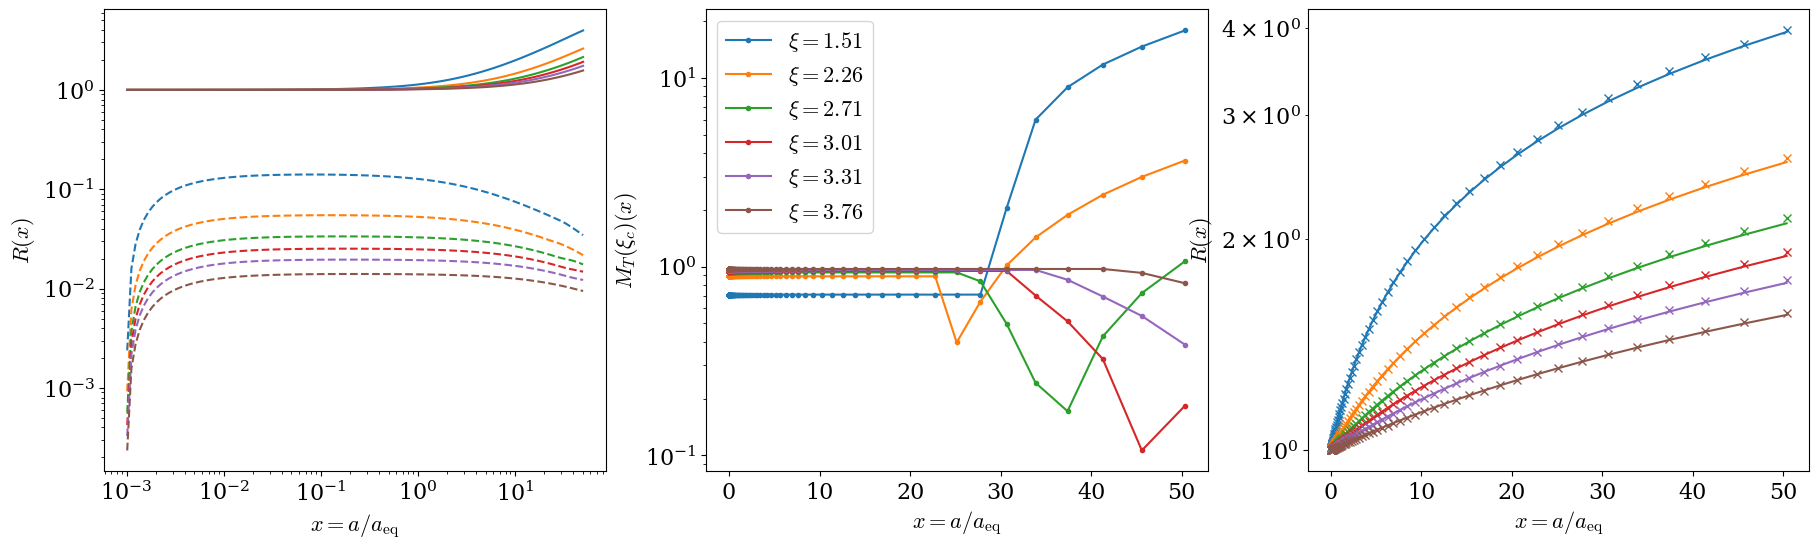

In [44]:
fig,ax=plt.subplots(1,3,figsize=(22,6))
for i_s in [100,150,180,200,220,250]:
    p = ax[0].loglog(xla,Rdla[:,i_s],label=r'$\xi=%.2f$'%xic[i_s])
    c = c=p[0].get_color()
    ax[0].loglog(xla,Pdla[:,i_s],'--',c=c)

    ax[1].semilogy(xla,bMTla[:,i_s],'.-',c=c,label=r'$\xi=%.2f$'%xic[i_s])

    ax[2].semilogy(xla,Rdla[:,i_s],'x',c=c)
    ax[2].semilogy(xla,np.sqrt(1- (bMTla[0,i_s]-1)*xla),c=c)
#ax[0].legend()
ax[1].legend()

ax[0].set_xlabel(r'$x=a/a_{\rm eq}$');ax[0].set_ylabel(r'$R(x)$')
ax[1].set_xlabel(r'$x=a/a_{\rm eq}$');ax[1].set_ylabel(r'$M_T(\xi_c)(x)$')
ax[2].set_xlabel(r'$x=a/a_{\rm eq}$');ax[2].set_ylabel(r'$R(x)$')

# Criteria

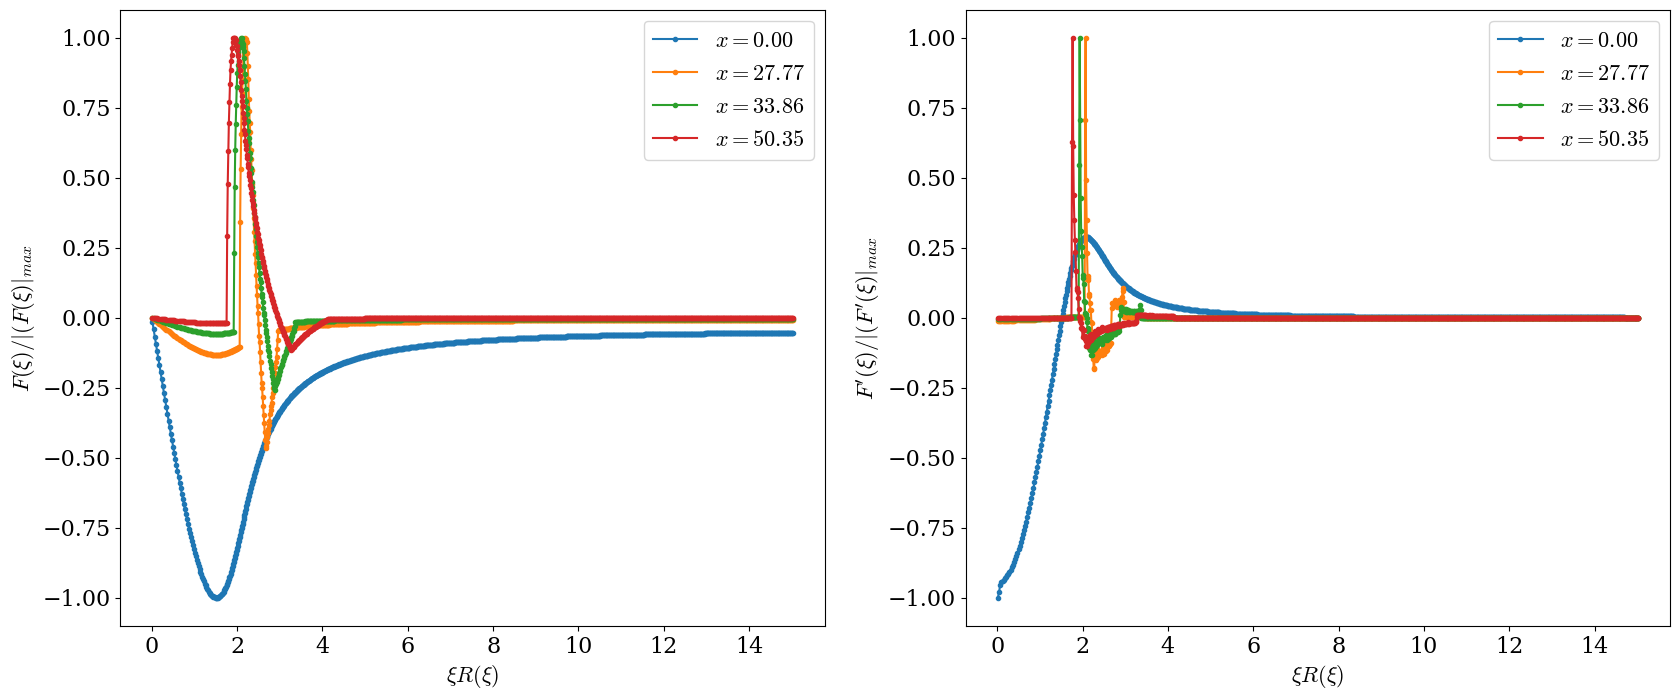

In [27]:
# First criteria

F = bMTla*0
Fp = bMTla*0

F = xic * (bMTla-1)
Fp = np.gradient(F,xic,axis=1)

# physical coordinate radius
for i in range(0,80):
    ri = xic*Rdla[i]

    # ordering based on distance to center
    ord_ri = np.argsort(ri)
    ri_ord = ri[ord_ri]

fig,ax=plt.subplots(1,2,figsize=(20,8))

for i in [0,-7,-5,-1]:
    ax[0].plot(ri,F[i]/np.abs(F[i]).max(),'.-',label=r'$x = %.2f$'%xl[i])
    ax[1].plot(ri,Fp[i]/np.abs(Fp[i]).max(),'.-',label=r'$x = %.2f$'%xl[i])
    
ax[0].set_xlabel(r'$\xi R(\xi)$');ax[0].set_ylabel(r'$F(\xi)/\vert(F(\xi)\vert_{max}$')
ax[1].set_xlabel(r'$\xi R(\xi)$');ax[1].set_ylabel(r'$F^\prime(\xi)/\vert(F^\prime(\xi)\vert_{max}$')

#ax[0].set_xlim(1.5,4.5)
#ax[1].set_xlim(1.5,4.5)

ax[0].legend()
ax[1].legend()

#plt.savefig('firstcritr2.pdf')

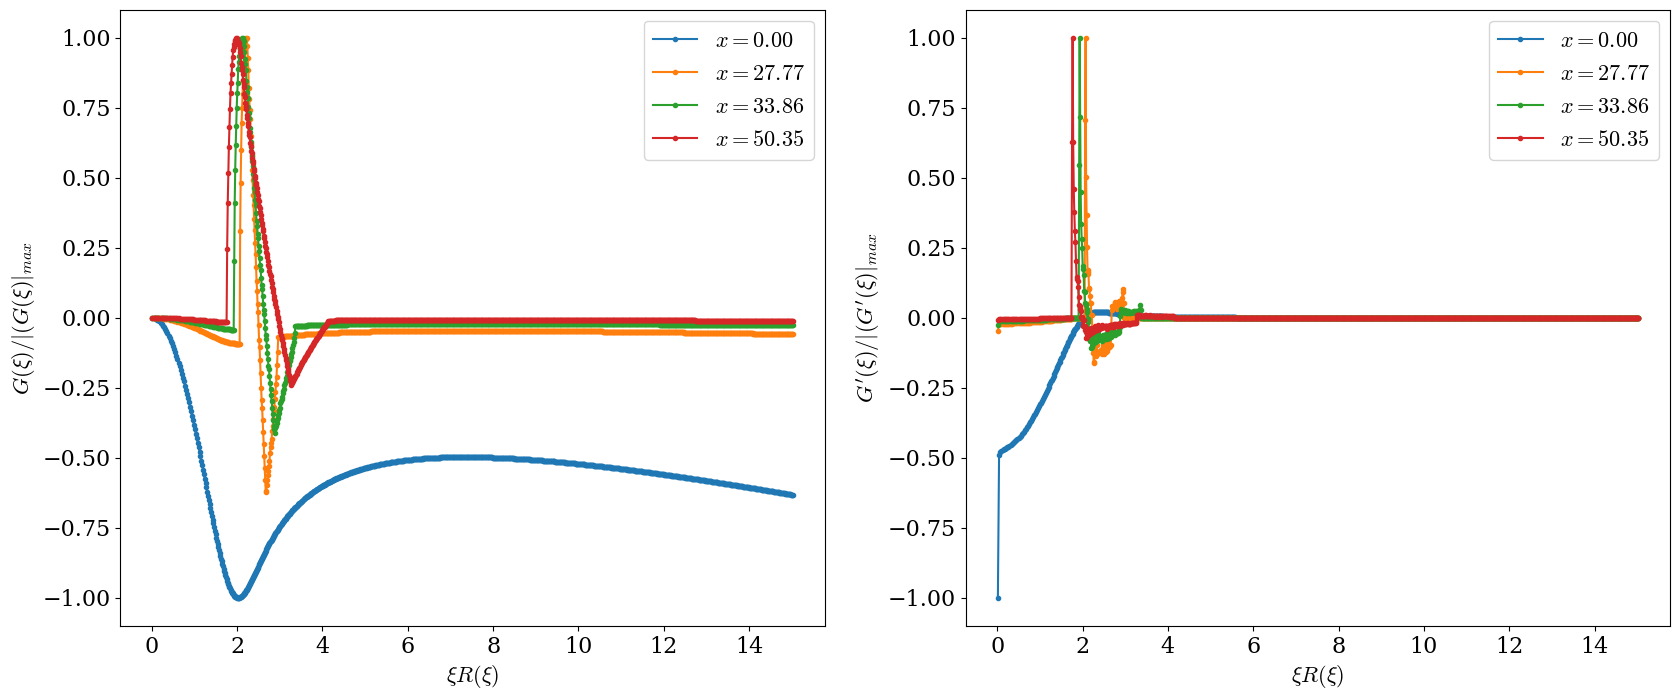

In [48]:
# Second criteria

G = bMTla*0
Gp = bMTla*0

G = (bMTla-1) * xic**2
Gp = np.gradient(G,xic,axis=1)/(2*xic)
Gpp= np.gradient(Gp,xic,axis=1)
        
fig,ax=plt.subplots(1,2,figsize=(20,8))

for i in [0,-7,-5,-1]:
    ax[0].plot(ri,G[i]/np.abs(G[i]).max(),'.-',label=r'$x = %.2f$'%xl[i])
    ax[1].plot(ri,Gp[i]/np.abs(Gp[i]).max(),'.-',label=r'$x = %.2f$'%xl[i])
    #ax[1].plot(ri,Gpp[i]/np.abs(Gpp[i]).max(),'.-',label=r'$x = %.2f$'%xl[i])
    
ax[0].set_xlabel(r'$\xi R(\xi)$');ax[0].set_ylabel(r'$G(\xi)/\vert(G(\xi)\vert_{max}$')
ax[1].set_xlabel(r'$\xi R(\xi)$');ax[1].set_ylabel(r'$G^\prime(\xi)/\vert(G^\prime(\xi)\vert_{max}$')

#ax[0].set_xlim(1.5,4.5)
#ax[1].set_xlim(1.5,4.5)

ax[0].legend()
ax[1].legend()

#plt.savefig('secondcritr2.pdf')

In [49]:
# Calculate x_caustic for each shell

Gp_max = xla*0
x_cas = xla*0

for i in range(len(xla)):
    for j in range(len(xic)-1):
        if j!=0 and Gp[i][j] > Gp[i][j-1] and Gp[i][j] > Gp[i][j+1]:
            Gp_max[i] = Gp[i][j]

x_cas = 1/Gp_max
#print(Gp_max)
print(x_cas[0]) #x_cas for initial time

24.67419751024358


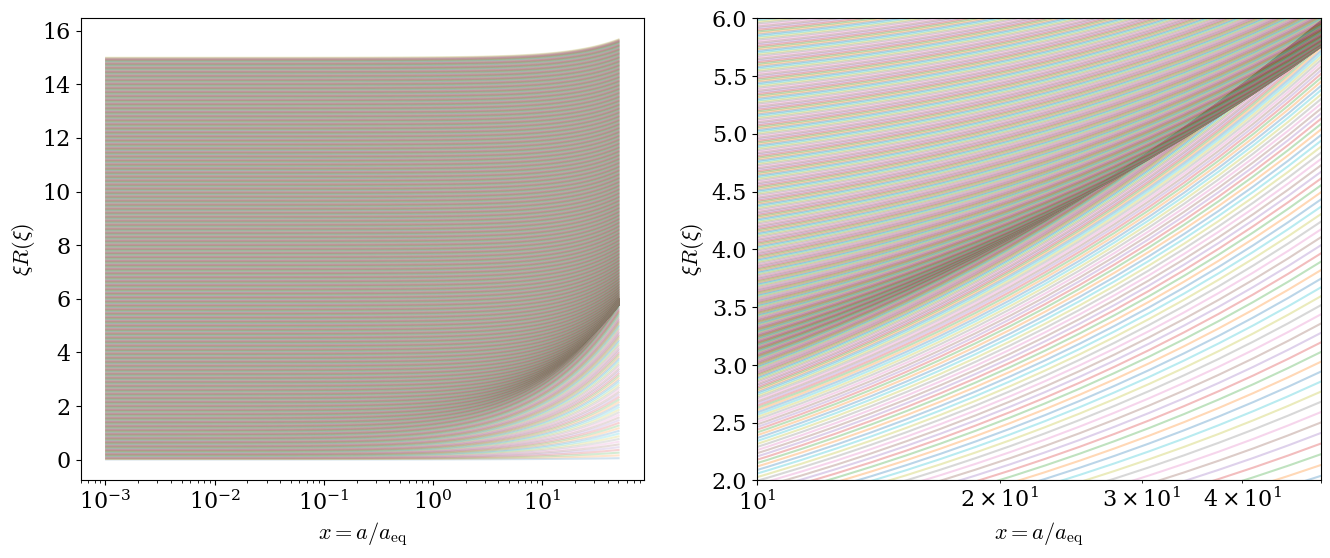

In [75]:
fig, ax=plt.subplots(1,2,figsize=(16,6))

for i in range(len(xic)):
    ax[0].semilogx(xla,xic[i]*Rdla[:,i],label=r'$\xi = %.2f$'%xic[i],alpha=0.2)
    ax[1].semilogx(xla,xic[i]*Rdla[:,i],label=r'$\xi = %.2f$'%xic[i],alpha=0.3)

ax[0].set_xlabel(r'$x=a/a_{\rm eq}$');ax[0].set_ylabel(r'$\xi R(\xi)$')
ax[1].set_xlabel(r'$x=a/a_{\rm eq}$');ax[1].set_ylabel(r'$\xi R(\xi)$')
ax[1].set_xlim(10,50);ax[1].set_ylim(2,6)

#plt.savefig('shellcrossingtest.pdf')

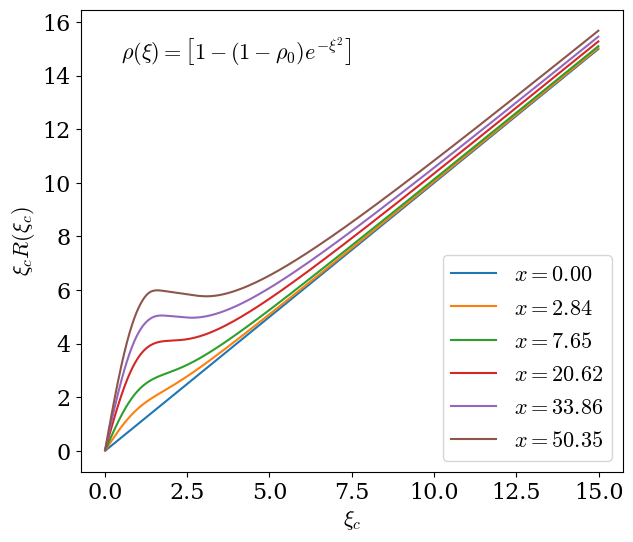

In [40]:
#Comoving displacement evolution
fig,ax=plt.subplots(1,1,figsize=(7,6))

for i in [0,-30,-20,-10,-5,-1]:#range(len(xla)):
    ax.plot(xic,xic*Rdla[i], label=r'$x = %.2f$'%xl[i])

ax.set_xlabel(r'$\xi_c$');ax.set_ylabel(r'$\xi_c R(\xi_c)$')
ax.legend(loc='lower right')
tex = r'$\rho(\xi)=\left[1-(1-\rho_0)e^{-\xi^2}\right]$'
ax.text(0.5,15.5,tex,fontsize=16,horizontalalignment='left',verticalalignment='top')

#plt.savefig('despcomovilR2.pdf')